# Model Determination for Customers' Responses.
**This notebook is divided into III parts:**
* Data Wrangling
* Model Development & Evaluation
* Model Application and Presentation


## I- Data Wrangling

Importing necessary libraries, followed by fetching the data from csv file into a dataframe.

In [3]:
!pip install --upgrade pip
!pip install jupyter
!pip install pandas
!pip install matplotlib
!pip install seaborn

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.model_selection import cross_val_score
from sklearn import metrics

/home/shehab/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [5]:
df = pd.read_csv('/home/shehab/Downloads/Recruiting_Task_InputData.csv')
print(df.head())

       name   age lifestyle  zip code family status        car     sports  \
0  VnSEFOuL  62.0    cozily   50168.0       married  practical  athletics   
1  8Tv0hcce  34.0    active   66479.0       married  expensive     soccer   
2  Zny9ysbk  69.0   healthy   16592.0        single  expensive  badminton   
3  HV3xCamM  57.0    cozily   50068.0       married  practical     soccer   
4  sflRsQ6v  66.0    cozily   35988.0        single  practical  badminton   

   earnings living area        label  
0  102526.0       urban  no response  
1   33006.0       urban  no response  
2  118760.0       urban     response  
3  131429.0       urban     response  
4   96003.0       urban     response  


* Checking data types and if any columns include empty fields.

In [6]:
print('nulls are \n' , df.isnull().sum())
print('count is \n' , df.count())
print("types are \n" , df.dtypes)

nulls are 
 name                0
age                 0
lifestyle           0
zip code            0
family status       0
car                 0
sports           1500
earnings            0
living area         0
label               0
dtype: int64
count is 
 name             10000
age              10000
lifestyle        10000
zip code         10000
family status    10000
car              10000
sports            8500
earnings         10000
living area      10000
label            10000
dtype: int64
types are 
 name              object
age              float64
lifestyle         object
zip code         float64
family status     object
car               object
sports            object
earnings         float64
living area       object
label             object
dtype: object


**Few notes:**
 1. All 10000 rows from csv are fetched
 2. The column 'sports' include missing data for 1500 customers
 3. Following is a detailed check of 'sports' column to know best way of filling missing values.

In [4]:
print(df.sports.value_counts())

athletics    2853
badminton    2828
soccer       2819
Name: sports, dtype: int64


In [7]:
dummies_label = pd.get_dummies(df.label)
test_quick = pd.concat([df.sports, df.label, dummies_label ], axis = 1)
tested = test_quick.pivot_table(index='sports', columns='label',aggfunc='sum')
tested

no response             response         
label     no response response no response response
sports                                             
athletics      1906.0      0.0         0.0    947.0
badminton      1891.0      0.0         0.0    937.0
soccer         1897.0      0.0         0.0    922.0

* The three different sports are almost equally spread through customers, with no significant difference. Therefore, missing values will be left as 0s when the columns are transfered to dummies for further steps of classification.

In [8]:
df.describe(include = 'all')

,name,age,lifestyle,zip code,family status,car,sports,earnings,living area,label
count,10000,10000.000000,10000,10000.000000,10000,10000,8500,10000.000000,10000,10000
unique,10000,NaN,3,NaN,2,2,3,NaN,2,2
top,VnSEFOuL,NaN,active,NaN,married,practical,athletics,NaN,urban,no response
freq,1,NaN,3375,NaN,5032,5051,2853,NaN,6300,6640
mean,NaN,42.090700,NaN,55227.270600,NaN,NaN,NaN,85337.799600,NaN,NaN
std,NaN,15.874416,NaN,26139.756227,NaN,NaN,NaN,37554.523323,NaN,NaN
min,NaN,15.000000,NaN,10003.000000,NaN,NaN,NaN,20006.000000,NaN,NaN
25%,NaN,28.000000,NaN,32708.250000,NaN,NaN,NaN,53237.250000,NaN,NaN
50%,NaN,42.000000,NaN,55290.000000,NaN,NaN,NaN,85617.500000,NaN,NaN
75%,NaN,56.000000,NaN,77967.750000,NaN,NaN,NaN,118111.000000,NaN,NaN


In [14]:
zip_["zip code"] = df["zip code"]
zip_.describe(include='all')

count     10001.0
unique     9451.0
top       68953.0
freq          3.0
Name: zip code, dtype: float64

**Further notes:**
 1. Age and earnings show reasonable numbers; no negative values and no strange ages.
 2. Names will be excluded from features list, specially that no names are repeated, which proves, it doesn't play role in customers' behavior.
 3. Zip codes may play role, customers in certain areas are more interested than others, BUT this is not the case since the most repeated zip code had frequency of only 3 out of 10000 observation.
 
Following is, exclusion of names and zip codes, as well as transfering all categorical data to dummies. Finally, the 'label' column will be the target which is further noted as 'y' downstream the notebook (slight changes may occur).

In [10]:
test_df = []
test_df = df[['age','earnings']]
life_sty = pd.get_dummies(df.lifestyle)
fam_stat = pd.get_dummies(df['family status'])
car_     = pd.get_dummies(df.car)
sports_  = pd.get_dummies(df.sports)
liv_area = pd.get_dummies(df['living area'])

test_df = pd.concat([test_df, life_sty, fam_stat, car_, sports_, liv_area], axis = 1)
test_df['label'] = df['label'].apply(lambda x: 1 if (x == 'response')  else 0)
test_df.head()

,age,earnings,active,cozily,healthy,married,single,expensive,practical,athletics,badminton,soccer,rural,urban,label
0,62.0,102526.0,0,1,0,1,0,0,1,1,0,0,0,1,0
1,34.0,33006.0,1,0,0,1,0,1,0,0,0,1,0,1,0
2,69.0,118760.0,0,0,1,0,1,1,0,0,1,0,0,1,1
3,57.0,131429.0,0,1,0,1,0,0,1,0,0,1,0,1,1
4,66.0,96003.0,0,1,0,0,1,0,1,0,1,0,0,1,1


### This is a classification problem
1. First is preprocessing the data (next two cells)
2. Then four models of classification will be tested 
    * K-nearest neighbors
    * Logistic regression
    * Decision tree
    * Support-vector machine
3. Parameters and conditions for each model will be tuned to achieve best performance
4. Accuracy score will be used for comparing the models to choose the best at the end


In [11]:
#All columns without 'label' will be the features
x = test_df.iloc[:,:-1].values 
y = test_df['label'].values

In [12]:
#All features will be standardized, this gives the data zero mean and unit variance
X = preprocessing.StandardScaler().fit(x).transform(x.astype(float))

## II- Model Development & Evaluation

### Model 1. K-nearest neighbors
The following function is created to identify best number of neighbors to be set as 'K', and determine best ratio of data samples to serve as test sample for the model.

In [19]:
def Ks_and_test_size(Ks,test_size):
    '''
    This function takes number of K and test size as inputs and returns a plot wiht
    accuracy metric for each K value.
    '''
    # data will be split to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=test_size, random_state=4)
    Ks = Ks
    mean_acc = np.zeros((Ks-1))
    std_acc = np.zeros((Ks-1))
    
    # accuracy count will be calculated for each K value
    for n in range(1,Ks):
        # K-nearest neighbor object (model)
        neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
        yhat=neigh.predict(X_test)
        mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
        std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
    # Ploting curve with mean accuracy value for each K surrounded with 1 
    # and 3 standard deviation 
    plt.plot(range(1,Ks),mean_acc,'g')
    plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
    plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
    plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Number of Neighbors (K)')
    plt.tight_layout()
    plt.show()
    print('The max accuracy score is ', max(mean_acc), ', corresponding to K = ', np.argmax(mean_acc)+1)

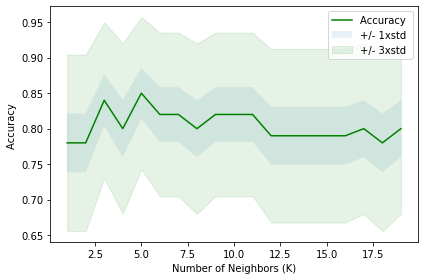

The max accuracy score is  0.85 , corresponding to K =  5


In [20]:
Ks_and_test_size(20,0.01)

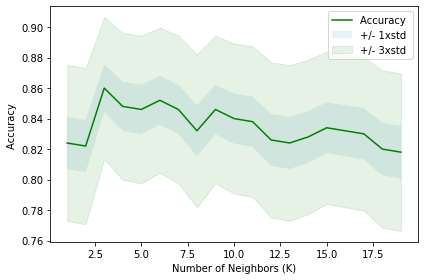

The max accuracy score is  0.86 , corresponding to K =  3


In [21]:
Ks_and_test_size(20,0.05)

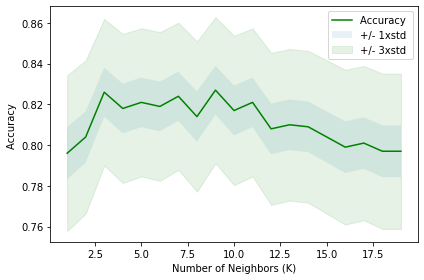

The max accuracy score is  0.827 , corresponding to K =  9


In [22]:
Ks_and_test_size(20,0.1)

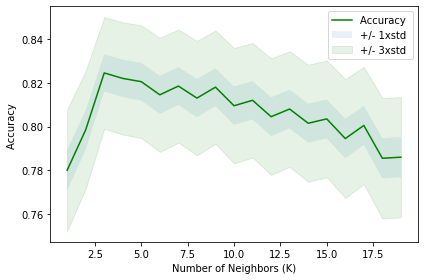

The max accuracy score is  0.8245 , corresponding to K =  3


In [23]:
Ks_and_test_size(20,0.2)

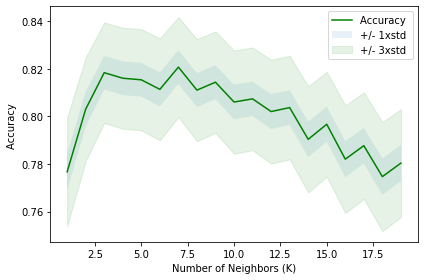

The max accuracy score is  0.8206666666666667 , corresponding to K =  7


In [24]:
Ks_and_test_size(20,0.3)

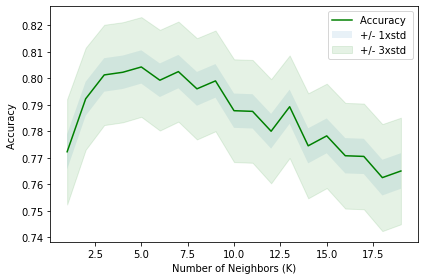

The max accuracy score is  0.80425 , corresponding to K =  5


In [25]:
Ks_and_test_size(20,0.4)

### Model 2. Logistic regression
The following function is created to identify best number for C (antiregularization), solver, and determine best ratio of data samples to serve as test sample for the model.

In [26]:
def LR_test_size(C , solver ,min_test_size, max_test_size):
    '''
    This function takes number of C, solver, min and max test size as inputs and returns 
    a plot wiht accuracy metric for each set of inputs.
    '''
    max_= max_test_size
    min_= min_test_size
    mean_acc = np.zeros((  round((max_-min_)/0.05)   ))
    std_acc  = np.zeros((  round((max_-min_)/0.05)   ))
    
    n = min_
    ind = 0
    while True: 
        if ind == len(mean_acc):
            break
        # data will be split to training and testing sets
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = n, random_state=4)
        #logistic regression object (model)
        LR   = LogisticRegression(C = C, solver = solver).fit(X_train,y_train)
        yhat = LR.predict(X_test)
        # accuracy count will be calculated for each testing set
        mean_acc[ind] = metrics.accuracy_score(y_test, yhat)
        std_acc[ind]  = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
        ind = ind + 1
        n = n + 0.05
        
    # Ploting curve with mean accuracy value for each set of inputs surrounded with 1 
    # and 3 standard deviation 
    mean_acc = np.array(mean_acc, dtype=np.float)
    std_acc = np.array(std_acc, dtype=np.float)
    plt.plot(np.arange(min_, max_, 0.05),mean_acc,'g')   
    plt.fill_between(np.arange(min_, max_, 0.05),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
    plt.fill_between(np.arange(min_, max_, 0.05),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
    plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Ratio of test sample')
    plt.tight_layout()
    plt.show()
    print('The max accuracy score is ', max(mean_acc))

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


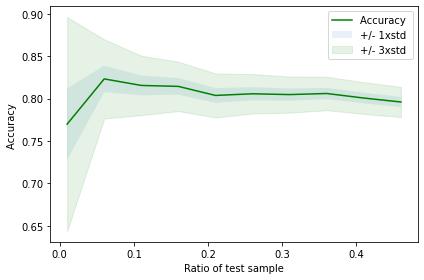

The max accuracy score is  0.8233333333333334


In [32]:
#‘liblinear’, ‘newton-cg’, ‘sag’, ‘saga’, ‘lbfgs’ 
LR_test_size(0.01, 'lbfgs', 0.01, 0.5)

### Model 3. Decision tree
* The following function is created to identify best value for the maximum depth of the tree.
* Afterwards comes closely similar function for determining best ratio of data samples to serve as test sample for the model.

In [13]:
def tree_depth(max_depth,test_size):
    '''
    This function takes max depth, test size as inputs and returns 
    a plot wiht accuracy metric for each depth.
    '''
    # data will be split to training and testing sets
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=test_size, random_state=4)
    depth = max_depth
    mean_acc = np.zeros((depth-1))
    std_acc = np.zeros((depth-1))

    for n in range(1,depth):
        #decision tree object (model)
        decTree = DecisionTreeClassifier(criterion="entropy", max_depth = depth,random_state=4).fit(X_train,y_train)
        predTree  = decTree.predict(X_test)
        # accuracy count will be calculated for each depth
        mean_acc[n-1] = metrics.accuracy_score(y_test, predTree)
        std_acc[n-1]=np.std(predTree==y_test)/np.sqrt(predTree.shape[0])
    
    # Ploting curve with mean accuracy value for each depth, surrounded with 1 
    # and 3 standard deviation 
    plt.plot(range(1,depth),mean_acc,'g')
    plt.fill_between(range(1,depth),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
    plt.fill_between(range(1,depth),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
    plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Max Depth')
    plt.tight_layout()
    plt.show()
    print('The max accuracy score is ', max(mean_acc), ', corresponding to depth = ', np.argmax(mean_acc)+1)

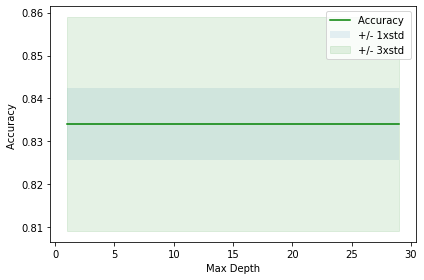

The max accuracy score is  0.834 , corresponding to depth =  1


In [68]:
tree_depth(30,0.2)

In [14]:
def tree_test_size(max_depth,min_test_size, max_test_size):
    '''
    This function takes max depth, min and max test size as inputs and returns 
    a plot wiht accuracy metric for each test size.
    '''
    max_= max_test_size
    min_= min_test_size
    mean_acc = np.zeros((  round((max_-min_)/0.05)   ))
    std_acc  = np.zeros((  round((max_-min_)/0.05)   ))
    n = min_
    ind = 0
    while True: 
        if ind == len(mean_acc):
            break
        # data will be split to training and testing sets
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = n, random_state=4)
        #decision tree object (model)
        decTree   = DecisionTreeClassifier(criterion="entropy", max_depth = max_depth,random_state=4).fit(X_train,y_train)
        predTree  = decTree.predict(X_test)
        # accuracy count will be calculated for each test set 
        mean_acc[ind] = metrics.accuracy_score(y_test, predTree)
        std_acc[ind]  = np.std(predTree==y_test)/np.sqrt(predTree.shape[0])
        ind = ind + 1
        n = n + 0.05
        
    # Ploting curve with mean accuracy value for each test size, surrounded with 1 
    # and 3 standard deviation 
    mean_acc = np.array(mean_acc, dtype=np.float)
    std_acc = np.array(std_acc, dtype=np.float)
    plt.plot(np.arange(min_, max_, 0.05),mean_acc,'g')   
    plt.fill_between(np.arange(min_, max_, 0.05),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
    plt.fill_between(np.arange(min_, max_, 0.05),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
    plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Ratio of test sample')
    plt.tight_layout()
    plt.show()
    print('The max accuracy score is ', max(mean_acc))
    print(mean_acc)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


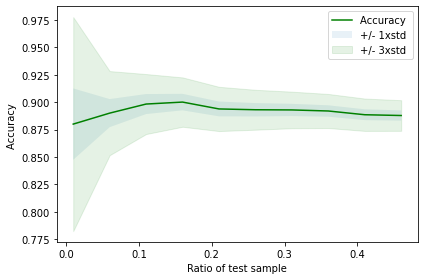

The max accuracy score is  0.9000624609618988
[0.88       0.89       0.8982743  0.90006246 0.89380952 0.89307692
 0.89290323 0.89194444 0.88853659 0.88782609]


In [15]:
tree_test_size(2,0.01, 0.5)

### Model 4. Support-vector machine
The following function is created to identify best kernel type, and determine best ratio of data samples to serve as test sample for the model.

In [78]:
def svm_kernel_test_size(kernel, min_test_size, max_test_size):
    '''
    This function takes kernel type, min and max test size as inputs and returns 
    a plot wiht accuracy metric for testing size.
    '''
    max_= max_test_size
    min_= min_test_size
    mean_acc = np.zeros((  round((max_-min_)/0.05)   ))
    std_acc  = np.zeros((  round((max_-min_)/0.05)   ))
    n = min_
    ind = 0
    while True: 
        if ind == len(mean_acc):
            break
        # data will be split to training and testing sets
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = n, random_state=4)
        #support-vector machine (model)
        svm_model = svm.SVC(kernel=kernel).fit(X_train,y_train)
        yhat_svm = svm_model.predict(X_test)
        # accuracy count will be calculated for each testing size 
        mean_acc[ind] = metrics.accuracy_score(y_test, yhat_svm)
        std_acc[ind]  = np.std(yhat_svm==y_test)/np.sqrt(yhat_svm.shape[0])
        ind = ind + 1
        n = n + 0.05
        
    # Ploting curve with mean accuracy value for each test size, surrounded with 1 
    # and 3 standard deviation         
    mean_acc = np.array(mean_acc, dtype=np.float)
    std_acc = np.array(std_acc, dtype=np.float)
    plt.plot(np.arange(min_, max_, 0.05),mean_acc,'g')   
    plt.fill_between(np.arange(min_, max_, 0.05),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
    plt.fill_between(np.arange(min_, max_, 0.05),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
    plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Ratio of test sample')
    plt.tight_layout()
    plt.show()
    print('The max accuracy score is ', max(mean_acc))

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


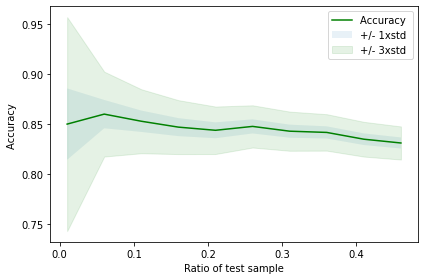

The max accuracy score is  0.86


In [85]:
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
svm_kernel_test_size('rbf', 0.01, 0.5)

## III- Model Application and Presentation

1- The model with highest accuracy score (**0.898**) is the **decision tree** will be presented and a confusion matrix will be created.

2- **Logistic regression** will be also used for determining the customer with highest probability to respond, which will be considered as the ideal customer.

**1-** Training a **decision tree** model with optimal parameters, determined already above.

In [20]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15, random_state=4)
#decision tree object (model)
decTree   = DecisionTreeClassifier(criterion="entropy", max_depth = 2,random_state=4).fit(X_train,y_train)
predTree  = decTree.predict(X_test)

The following function is used to plot the confusion matrix

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[401  94]
 [ 57 948]]


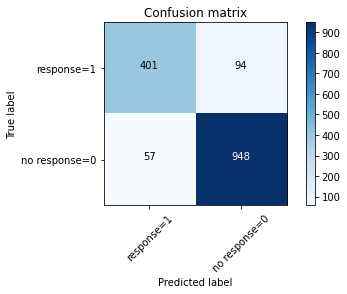

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predTree, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['response=1','no response=0'],normalize= False,  title='Confusion matrix')

**2-** Training a **Logistic regression** model to determine the customer with highest probability of responding.

In [177]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.05, random_state=4)
LR   = LogisticRegression(C = 0.01, solver = 'lbfgs').fit(X_train,y_train)

In [174]:
# trial_df is equivalent to original dataframe but with probabilities of responding
trial_df=df[['name', 'age', 'lifestyle', 'zip code', 'family status', 'car','sports', 'earnings', 'living area']]
trial_df['proba']= LR.predict_proba(X)[:,1]
ideal = trial_df[trial_df["proba"] == max(trial_df["proba"])]
ideal.head()

,name,age,lifestyle,zip code,family status,car,sports,earnings,living area,proba
5930,NLRP5nIR,69.0,cozily,33619.0,married,practical,NaN,149239.0,urban,0.872824


**An overview of top 10 customers**

In [180]:
trial_df.sort_values(by=['proba'], ascending=False).head(10)

,name,age,lifestyle,zip code,family status,car,sports,earnings,living area,proba
5930,NLRP5nIR,69.0,cozily,33619.0,married,practical,NaN,149239.0,urban,0.872824
8870,8IZX4Ibl,69.0,active,33276.0,single,practical,NaN,145998.0,rural,0.869986
4594,34UDY7tV,69.0,healthy,41310.0,single,expensive,soccer,149630.0,urban,0.868554
5710,IE4Gudzt,69.0,active,44027.0,married,practical,NaN,149522.0,urban,0.865897
4977,cn3UdDWz,69.0,healthy,60469.0,married,expensive,NaN,139824.0,urban,0.864299
5591,Hw5CYSS4,69.0,cozily,28133.0,single,expensive,athletics,146890.0,urban,0.864078
9999,eBED7EpQ,69.0,healthy,90816.0,single,practical,athletics,149683.0,rural,0.864054
1437,kC6415B9,69.0,cozily,54912.0,single,practical,athletics,149575.0,urban,0.862858
4722,rpBV49cc,69.0,healthy,25576.0,married,practical,NaN,139759.0,rural,0.861594
5728,RbTlN9wy,69.0,active,63838.0,single,expensive,NaN,135039.0,rural,0.860355
